Loading the dataset

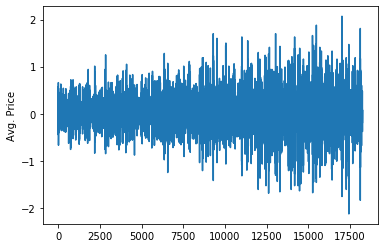

In [34]:
import os
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('C:\\Users\\Mirela\\PycharmProjects\\Avocado\\avocado.csv',
                      usecols=[2]).values.astype('float32')


def delta_time_series(data):
    return data[1:] - data[:-1]

dataset = delta_time_series(dataset)

dataset.shape


def plot_delta(data):
    plt.plot(delta_time_series(data))
    plt.ylabel('Avg. Price')
    plt.show()

plot_delta(dataset)

In [35]:
# Helper function to get y as a numpy array from the TimeseriesGenerator
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y



In [38]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [39]:
# split into train and test sets

train, val, test = dataset[0:12000, :], dataset[12001:13000, :], dataset[13001:None, :]

lookback = 84
step = 2
batch_size = 128

train_data_gen = TimeseriesGenerator(train, train,
                                     length=lookback, sampling_rate=step, stride=1,shuffle=True,
                                     batch_size=batch_size)

val_data_gen = TimeseriesGenerator(val, val,
                                   length=lookback, sampling_rate=step, stride=1,
                                   batch_size=batch_size)

test_data_gen = TimeseriesGenerator(test, test,
                                    length=lookback, sampling_rate=step, stride=1,
                                    batch_size=batch_size)

val_steps = (13000 - 12001 - lookback)
test_steps = (len(dataset) - 13001 - lookback)

Epoch 1/10
500/500 [==============================] - 26s 51ms/step - loss: 0.0449 - val_loss: 0.0727
Epoch 2/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0401 - val_loss: 0.0546
Epoch 3/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0396 - val_loss: 0.0729
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0393 - val_loss: 0.0602
Epoch 5/10
500/500 [==============================] - 25s 49ms/step - loss: 0.0395 - val_loss: 0.0445
Epoch 6/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0393 - val_loss: 0.0391
Epoch 7/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0392 - val_loss: 0.0849
Epoch 8/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0389 - val_loss: 0.0912
Epoch 9/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0391 - val_loss: 0.0668
Epoch 10/10
500/500 [==============================] - 24s 48ms/step - loss: 0.038

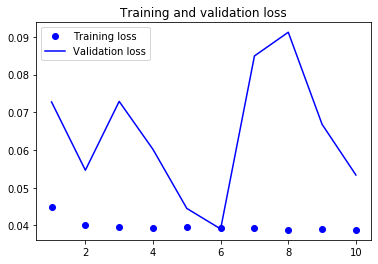

In [40]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, dataset.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_data_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()